# Dataset: Dermnet

## Contexto

Este conjunto de dados consiste em uma coleção de imagens representando 23 tipos distintos de doenças de pele. As imagens foram obtidas a partir do site [Dermnet](https://dermnetnz.org/topics/otitis-externa). O conjunto de dados contém aproximadamente 19.500 imagens, divididas em conjuntos de treino e teste, com cerca de 15.500 imagens no conjunto de treino e o restante no conjunto de teste.

## Conteúdo

As imagens estão no formato JPEG e possuem 3 canais (RGB). As resoluções das imagens variam, não sendo todas de alta resolução. As categorias das doenças incluem acne, melanoma, eczema, queratoses seborreicas, tinea (dermatofitose), doenças bolhosas, hera venenosa, psoríase, tumores vasculares, entre outras.

Este conjunto de dados oferece várias oportunidades de análise e aplicação, incluindo:

- Desenvolvimento de classificadores de imagens robustos para categorização automática de imagens em uma das 23 doenças identificadas.
- Análise exploratória das imagens para identificar diferenças visuais entre as categorias e fazer inferências sobre os padrões de cada doença.
- Agrupamento de imagens de diferentes doenças em categorias mais amplas para análise comparativa.
- Entre outras possibilidades de investigação e aplicação na área da dermatologia e reconhecimento de padrões.


In [25]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
import os
import pandas as pd
from glob import glob
import shutil
import cv2
import random
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report

In [3]:
def confussion_matrix(y_true_labels,y_pred_labels,test_generator):
    # Calcular a matriz de confusão
    cm = confusion_matrix(y_true_labels, y_pred_labels)

    # Exibir a matriz de confusão
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Calcular os verdadeiros positivos (TP), verdadeiros negativos (TN),
    # falsos positivos (FP) e falsos negativos (FN)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    # Exibir o relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=test_generator.class_indices.keys()))

    # Exibir a tabela com os valores de TP, TN, FP, FN
    print("\nValores de TP, TN, FP, FN:")
    print("Verdadeiros Positivos:", TP)
    print("Verdadeiros Negativos:", TN)
    print("Falsos Positivos:", FP)
    print("Falsos Negativos:", FN)

In [4]:
# Função para guardar os modelos
def save_model(model, model_name, history, test_generator): 
    # Criar uma pasta para guardar os modelos se esta não existir
    if not os.path.exists('Modelos_Salvos'):
        os.mkdir('Modelos_Salvos')
    
    # Criar uma pasta para guardar o modelo se esta não existir
    if not os.path.exists('Modelos_Salvos/' + model_name):
        os.mkdir('Modelos_Salvos/' + model_name)
    
    # Guardar o modelo
    model.save('Modelos_Salvos/' + model_name + '/' + model_name + '.keras')
    model.save('Modelos_Salvos/' + model_name + '/' + model_name + '.h5')

    # Guardar a avaliação do modelo usando o gerador de teste
    #evaluate_model(model, history, test_generator, test_folder)
    plt.savefig('Modelos_Salvos/' + model_name + '/' + model_name + '_avaliacao.png')

    # Guardar a arquitetura do modelo
    tf.keras.utils.plot_model(
        model,
        to_file='Modelos_Salvos/' + model_name + '/' + model_name + '.png',
        show_shapes=True,
        show_layer_names=True,
    )

    # Guardar o histórico do modelo num ficheiro CSV
    hist_df = pd.DataFrame(history.history)
    hist_csv_file = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

In [20]:
# Função para carregar o modelo e seu histórico
def load_model_and_history(model_name):
    # Verifica se o modelo existe
    model_path = 'Modelos_Salvos/' + model_name + '/' + model_name + '.h5'
    if not os.path.exists(model_path):
        print("O modelo especificado não existe.")
        return None, None
    
    # Carrega o modelo
    model = tf.keras.models.load_model(model_path)
    
    # Carrega o histórico
    history_path = 'Modelos_Salvos/' + model_name + '/' + model_name + '_historico.csv'
    if os.path.exists(history_path):
        history = pd.read_csv(history_path)
    else:
        print("O histórico do modelo não existe.")
        history = None
    
    return model, history

In [5]:
SIZE = 250

In [6]:
INPUT_SHAPE = (SIZE, SIZE, 3) 

In [7]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(5, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 256)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 61, 61, 128)       0

In [9]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode='reflect')

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# train_dir = '/kaggle/input/skin-disease-dataset/Dataset'

train_dir= 'C:/Dev/DataProcessedUnder/train'
test_dir = 'C:/Dev/DataProcessedUnder/test'

In [12]:
batch_size = 64

In [13]:
train_generator = train_datagen.flow_from_directory(
                                            directory = train_dir,
                                            class_mode = 'categorical',
                                            batch_size = batch_size,
                                            target_size = (SIZE, SIZE))

Found 2251 images belonging to 5 classes.


In [14]:
test_generator = test_datagen.flow_from_directory(
                                    directory = test_dir,
                                    class_mode = 'categorical',
                                    batch_size = batch_size,
                                    target_size = (SIZE, SIZE))

Found 746 images belonging to 5 classes.


In [15]:
history=model.fit(
        train_generator,
        steps_per_epoch=2000 // batch_size,  
        epochs=25,
        #validation_data=test_generator,
        #validation_steps=800 // batch_size
)

Epoch 1/25
31/31 [==============================] - 1477s 47s/step - loss: 2.3476 - acc: 0.2346
Epoch 2/25
31/31 [==============================] - 1153s 37s/step - loss: 1.6095 - acc: 0.1999
Epoch 3/25
31/31 [==============================] - 1095s 35s/step - loss: 1.5960 - acc: 0.2154
Epoch 4/25
31/31 [==============================] - 1153s 37s/step - loss: 1.5705 - acc: 0.2745
Epoch 5/25
31/31 [==============================] - 1132s 36s/step - loss: 1.5647 - acc: 0.2895
Epoch 6/25
31/31 [==============================] - 1172s 38s/step - loss: 1.5566 - acc: 0.3200
Epoch 7/25
31/31 [==============================] - 1255s 41s/step - loss: 1.5325 - acc: 0.3347
Epoch 8/25
31/31 [==============================] - 1155s 37s/step - loss: 1.5035 - acc: 0.3490
Epoch 9/25
31/31 [==============================] - 1115s 36s/step - loss: 1.5143 - acc: 0.3537
Epoch 10/25
31/31 [==============================] - 1169s 38s/step - loss: 1.4864 - acc: 0.3342
Epoch 11/25
31/31 [====================

In [16]:
model.evaluate(test_generator)

12/12 [==============================] - 46s 3s/step - loss: 1.3214 - acc: 0.4464


[1.3213673830032349, 0.44638070464134216]

In [17]:
# Guardar o modelo99
save_model(model, 'CNN2D', history, test_generator)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<Figure size 640x480 with 0 Axes>

Modelo carregado com sucesso!
Arquitetura do modelo:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 256)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 124, 124, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 128)      0         
 2D)                                                             
                                                                 
 dr

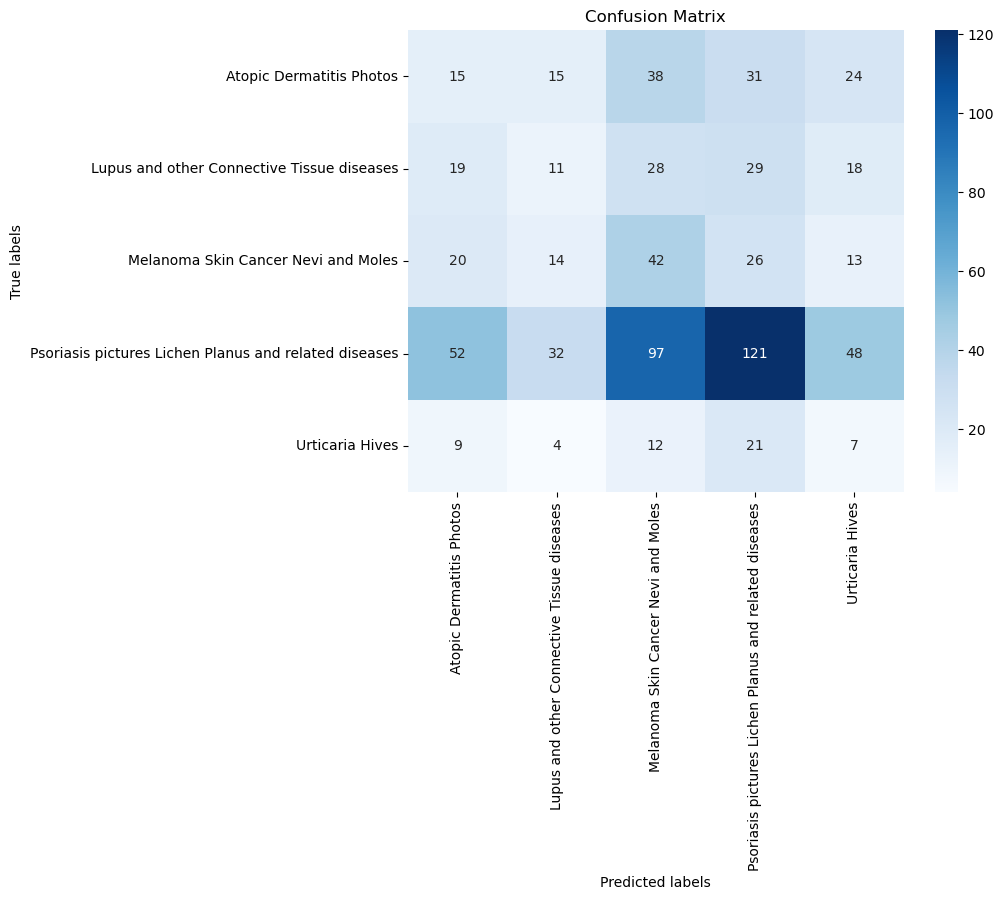


Relatório de Classificação:
                                                       precision    recall  f1-score   support

                             Atopic Dermatitis Photos       0.13      0.12      0.13       123
           Lupus and other Connective Tissue diseases       0.14      0.10      0.12       105
                  Melanoma Skin Cancer Nevi and Moles       0.19      0.37      0.25       115
Psoriasis pictures Lichen Planus and related diseases       0.53      0.35      0.42       350
                                      Urticaria Hives       0.06      0.13      0.09        53

                                             accuracy                           0.26       746
                                            macro avg       0.21      0.21      0.20       746
                                         weighted avg       0.33      0.26      0.28       746


Valores de TP, TN, FP, FN:
Verdadeiros Positivos: 11
Verdadeiros Negativos: 15
Falsos Positivos: 15
Falsos Negat

In [26]:
loaded_model_CNN_random, loaded_history_CNN_random = load_model_and_history('CNN2D')
if loaded_model_CNN_random is not None:
    print("Modelo carregado com sucesso!")
    print("Arquitetura do modelo:")
    loaded_model_CNN_random.summary()
    if loaded_history_CNN_random is not None:
        print("Histórico do modelo:")
        print(loaded_history_CNN_random.head())  # Visualizar as primeiras linhas do histórico

print("\nA fazer previsões no modelo...")
# Fazer previsões no conjunto de teste usando o modelo carregado
loaded_model_predictions = loaded_model_CNN_random.predict(test_generator)

# Converter as previsões em rótulos
y_pred_labels = np.argmax(loaded_model_predictions, axis=1)
y_true_labels = test_generator.classes

# Agora você pode chamar a função de matriz de confusão
confussion_matrix(y_true_labels, y_pred_labels, test_generator)